# Notebook 4: Evaluation & Analysis

## Goals
1. Define Test Set (Select by Ticker)
2. Load Trained Model & Quantized Model
3. Run Inference
4. Compare Results (Accuracy, Speed)
5. Error Analysis

In [1]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from transformers import BertTokenizerFast, BertForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# ==========================================
# 1. CONFIGURATION: SELECT TEST TICKERS
# ==========================================
# Define which tickers belong to the TEST SET.
# These should ideally be companies that were NOT in the training set.

TEST_TICKERS = ['ADBE']  # <--- Update this list with your test tickers

print(f"Test Tickers: {TEST_TICKERS}")

Test Tickers: ['ADBE']


In [3]:
# Load Training Data (to filter for test set)
data_path = Path('../data/training_data.jsonl')

with open(data_path, 'r', encoding='utf-8') as f:
    raw_data = [json.loads(line) for line in f]
    
df_all = pd.DataFrame(raw_data)

# Extract ticker from source filename (e.g., 'AAPL.csv' -> 'AAPL')
df_all['ticker'] = df_all['metadata'].apply(lambda x: x['source'].replace('.csv', ''))

# Filter for Test Set
test_df = df_all[df_all['ticker'].isin(TEST_TICKERS)].copy().reset_index(drop=True)

if len(test_df) == 0:
    print("WARNING: No data found for specified test tickers! check spelling.")
else:
    print(f"Loaded {len(test_df)} test examples from {len(TEST_TICKERS)} companies.")
    display(test_df.head())

Loaded 56 test examples from 1 companies.


,input,output,metadata,ticker
0,[<START>] [<START>] [current_assets] [Cash and...,cash_and_equivalents,"{'source': 'ADBE.csv', 'is_calculated': False}",ADBE
1,[<START>] [Cash and cash equivalents] [current...,short_term_investments,"{'source': 'ADBE.csv', 'is_calculated': False}",ADBE
2,[Cash and cash equivalents] [Short-term invest...,accounts_receivable,"{'source': 'ADBE.csv', 'is_calculated': False}",ADBE
3,"[Short-term investments] [Trade receivables, n...",prepaid_expenses,"{'source': 'ADBE.csv', 'is_calculated': False}",ADBE
4,"[Trade receivables, net of allowances] [Prepai...",total_current_assets,"{'source': 'ADBE.csv', 'is_calculated': True}",ADBE


In [4]:
model_path = Path('../models/financial_transformer')
# Load Tokenizer
# CHANGED: Use BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained(model_path)
# Load Full Model
# CHANGED: Use BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(model_path)
model.to(device)
model.eval()
# Load Label Mappings
with open('../models/label_map.json', 'r') as f:
    label2id = json.load(f)
    id2label = {int(i): label for label, i in label2id.items()}
print("Model loaded.")

Model loaded.


In [5]:
# Run Inference (Batch Processing)
def predict(inputs, model, tokenizer, batch_size=32):
    predictions = []
    
    for i in range(0, len(inputs), batch_size):
        batch = inputs[i:i+batch_size]
        encodings = tokenizer(batch, truncation=True, padding=True, max_length=128, return_tensors='pt')
        
        # Move to device
        input_ids = encodings['input_ids'].to(device)
        attention_mask = encodings['attention_mask'].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            predictions.extend([id2label[p] for p in preds])
            
    return predictions

print("Running inference on Test Set...")
test_df['predicted'] = predict(test_df['input'].tolist(), model, tokenizer)
test_df['correct'] = test_df['predicted'] == test_df['output']

acc = test_df['correct'].mean()
print(f"\nTest Set Accuracy: {acc:.2%}")

Running inference on Test Set...

Test Set Accuracy: 100.00%


In [6]:
# Error Analysis
# Set pandas option to show full content
pd.set_option('display.max_colwidth', None)
errors = test_df[~test_df['correct']].copy()
print(f"Total Errors: {len(errors)}")
if len(errors) > 0:
    print("\nTop 20 Errors:")
    display(errors[['input', 'output', 'predicted']].head(20))
    
    # Most common confused pairs
    errors['pair'] = errors['output'] + " -> " + errors['predicted']
    print("\nMost common confusions (True -> Predicted):")
    print(errors['pair'].value_counts().head(20))

Total Errors: 0


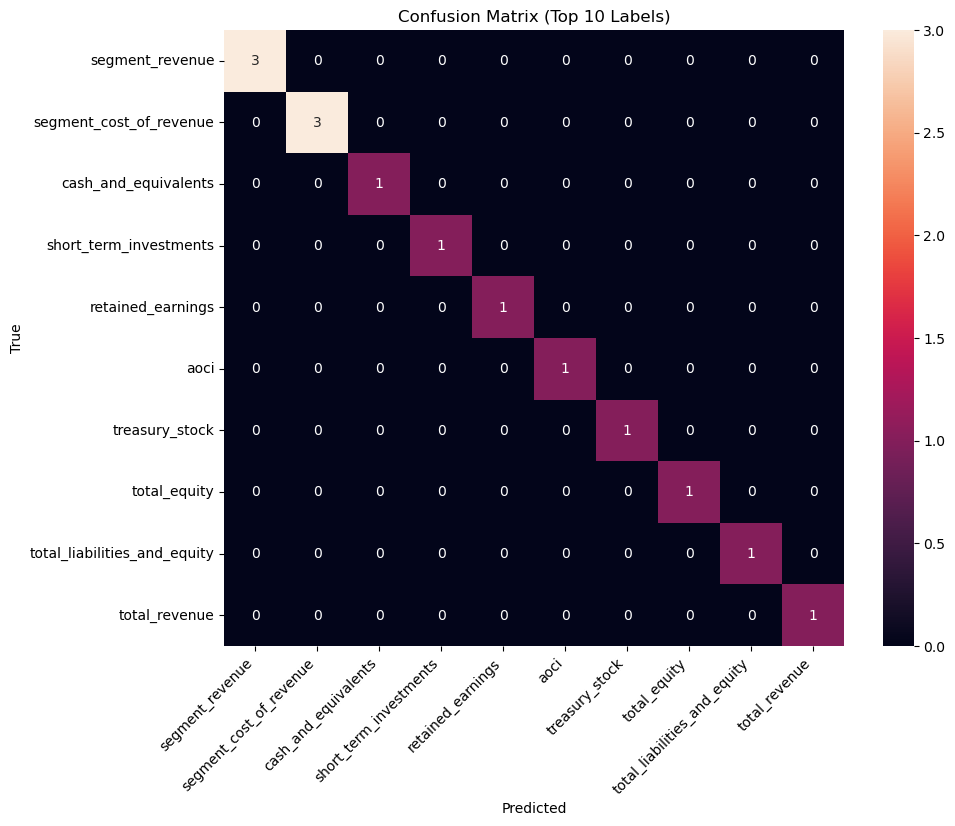

In [7]:
# Confusion Matrix for Top Labels
top_labels = test_df['output'].value_counts().head(10).index
filtered_df = test_df[test_df['output'].isin(top_labels) & test_df['predicted'].isin(top_labels)]

if len(filtered_df) > 0:
    cm = confusion_matrix(filtered_df['output'], filtered_df['predicted'], labels=top_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=top_labels, yticklabels=top_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Top 10 Labels)')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [8]:
# ==========================================
# OPTIONAL: COMPARE WITH QUANTIZED MODEL
# ==========================================
# quant_path = Path('../models/financial_transformer_quantized.pt')
# if quant_path.exists():
#     print("\nLoading Quantized Model for Comparison...")
#     # Load skeleton
#     # CHANGED: Use BertForSequenceClassification
#     model_q = BertForSequenceClassification.from_pretrained(model_path)
#     model_q.to('cpu') # Quantized usually runs on CPU
#     # Quantize structure to match saved weights
#     model_q = torch.quantization.quantize_dynamic(
#         model_q, {torch.nn.Linear}, dtype=torch.qint8
#     )
    
#     # Load weights
#     model_q.load_state_dict(torch.load(quant_path))
    
#     # Run Inference (CPU)
#     print("Running inference (Quantized)...")
#     # Note: We must run on CPU dictating device='cpu'
    
#     print("Quantized model loaded successfully.")
# else:
#     print("Quantized model not found.")

In [9]:
# ==========================================
# OPTIONAL: COMPARE WITH QUANTIZED MODEL
# ==========================================

# Run Inference
# print("Running inference on Test Set...")
# predicted_labels = []
# correct_predictions = 0
# for idx, row in test_df.iterrows():
#     text = row['input']
#     true_label = row['output']
    
#     # Tokenize
#     inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    
#     # Move to device
#     inputs = {k: v.to(device) for k, v in inputs.items()}
    
#     # Predict
#     with torch.no_grad():
#         outputs = model(**inputs)
#         logits = outputs.logits
#         predicted_class_id = torch.argmax(logits, dim=1).item()
        
#     predicted_label = id2label[predicted_class_id]
#     predicted_labels.append(predicted_label)
    
#     if predicted_label == true_label:
#         correct_predictions += 1
        
# # Add predictions to dataframe
# test_df['predicted'] = predicted_labels
# test_df['correct'] = test_df['predicted'] == test_df['output']
# accuracy = correct_predictions / len(test_df)
# print(f"\nTest Set Accuracy: {accuracy:.2%}")